# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import PIL
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets.mini_imagenet import MiniImageNet, Split
from datasets.utils import extract_archive

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset Sandbox

In [140]:
imnet_dir = "../../data/mini-imagenet"
omni_dir = "../../data/omni"
datadir = imnet_dir

In [14]:
from torchvision.transforms import Compose, ToTensor, Resize, Lambda
from torchvision.transforms.functional import InterpolationMode

im_size = 28

transform = ToTensor()
t_transform = Lambda(lambda x: torch.tensor(x))
greyscale = False

trainset = MiniImageNet(
    root=datadir,
    split=Split.TRAIN,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)
testset = MiniImageNet(
    root=datadir,
    split=Split.TEST,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)
valset = MiniImageNet(
    root=datadir,
    split=Split.VAL,
    transform=transform,
    target_transform=t_transform,
    greyscale=greyscale,
    download=True,
)

Computing MD5: /Users/ntraft/Development/data/mini-imagenet/train.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/train.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/train already exists.
Computing MD5: /Users/ntraft/Development/data/mini-imagenet/test.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/test.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/test already exists.
Computing MD5: /Users/ntraft/Development/data/mini-imagenet/val.tar
MD5 matches: /Users/ntraft/Development/data/mini-imagenet/val.tar
/Users/ntraft/Development/data/mini-imagenet/processed_images/val already exists.


In [16]:
# Select single dataset for targeted analysis.
ds = trainset

Training Set statistics:
64 classes
38400 examples


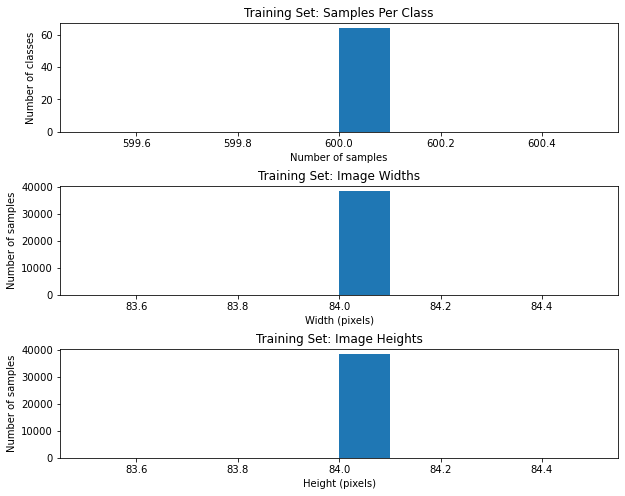

In [304]:
from collections import defaultdict


def show_image_classification_dataset_stats(name, dataset):
    """
    Show statistics for an image classification dataset.
    
    Args:
        name (str): Name of the dataset, like "Training" or "Validation".
        dataset (Dataset): A PyTorch dataset object.
    """
    title = name + " Set"
    print(f"Collecting {title} statistics...", end=" ", flush=True)
    total_size = 0
    class_sizes = []
    widths = []
    heights = []
    class_map = defaultdict(int)
    for img, label in dataset:
        class_map[int(label)] += 1
        if isinstance(img, PIL.Image.Image):
            widths.append(img.width)
            heights.append(img.height)
        else:
            widths.append(img.size()[-1])
            heights.append(img.size()[-2])
    class_sizes = list(class_map.values())
    print("done.")

    print(title, "statistics:")
    print(len(class_map), "classes")
    print(len(dataset), "examples")

    fig, (sax, wax, hax) = plt.subplots(3, figsize=(10, 8), gridspec_kw={"hspace": 0.5})
    sax.hist(class_sizes)
    sax.set_xlabel("Number of samples")
    sax.set_ylabel("Number of classes")
    sax.set_title(f"{title}: Samples Per Class")

    wax.hist(widths)
    wax.set_xlabel("Width (pixels)")
    wax.set_ylabel("Number of samples")
    wax.set_title(f"{title}: Image Widths")

    hax.hist(heights)
    hax.set_xlabel("Height (pixels)")
    hax.set_ylabel("Number of samples")
    hax.set_title(f"{title}: Image Heights")

    
show_image_classification_dataset_stats(str(ds.split), ds)

In [274]:
train_classes = frozenset(trainset.classes.keys())
print("Train classes:", len(train_classes))
test_classes = frozenset(testset.classes.keys())
print("Test classes:", len(test_classes))
val_classes = frozenset(valset.classes.keys())
print("Validation classes:", len(val_classes))

print("Overlap between train and test:", len(train_classes & val_classes))
print("Overlap between train and val:", len(train_classes & test_classes))
print("Overlap between val and test:", len(val_classes & test_classes))

Train classes: 64
Test classes: 20
Validation classes: 16
Overlap between train and test: 0
Overlap between train and val: 0
Overlap between val and test: 0


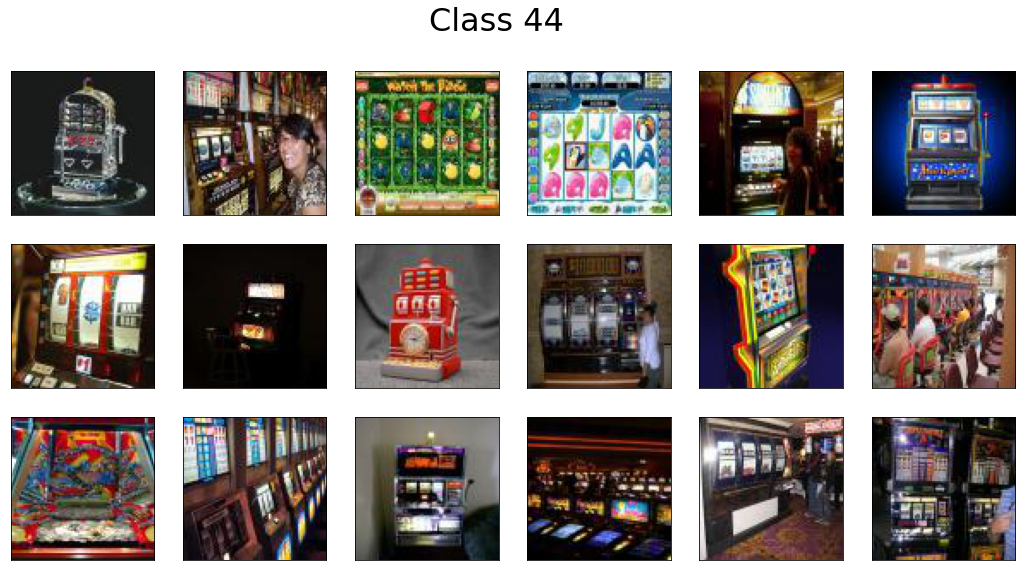

In [20]:
# Randomly sample from a random class and display the samples.
# NOTE: Assumes a dataset of type ClassIndexedDataset.
rows = 3
cols = 6
rng = np.random.default_rng()
one_class = rng.choice(ds.class_index)  # select a random class
#one_class = ds.class_index[24]  # select a specific class
indices = rng.choice(one_class, size=rows*cols, replace=False)
samples = [ds[i] for i in indices]

fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
fig.suptitle(f"Class {int(samples[0][1])}", fontsize=32)
for i, (img, _) in enumerate(samples):
    ax = axs[i//cols - 1, i%cols]
    if not isinstance(img, PIL.Image.Image):  # if not image, then must be array-like
        img = img.squeeze()
        if len(img.shape) == 3:
            img = img.permute(1, 2, 0)
    # cmap will be ignored if data is RGB(A) format, so this is compatible with both single- and multi-channel images.
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# ANML Training

In [141]:
from datasets.mini_imagenet import create_OML_sampler as imnet_sampler
from datasets.omniglot import create_OML_sampler as omni_sampler

sampler, input_shape = omni_sampler(root=omni_dir)
# sampler, input_shape = imnet_sampler(root=imnet_dir)

In [142]:
train_data, train_class, (valid_ims, valid_labels) = sampler.sample_train(batch_size=1, num_batches=20)

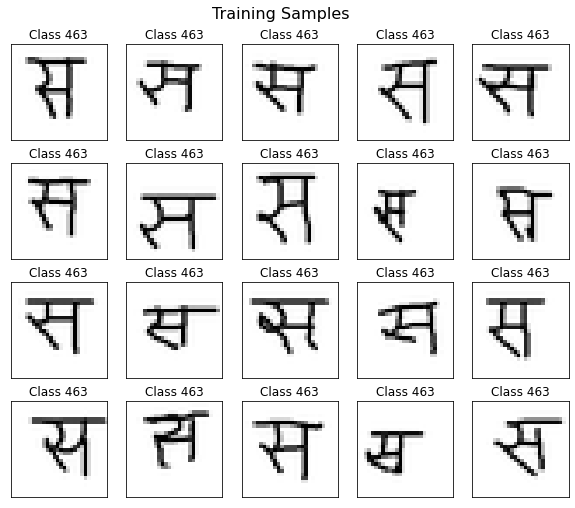

In [143]:
from itertools import chain

def calc_grid_dims(num_cells):
    if num_cells <= 8:
        return 1, num_cells
    rows = int(np.sqrt(num_cells))
    cols = int(np.ceil(num_cells / rows))
    return rows, cols

def display_samples(samples):
    rows, cols = calc_grid_dims(len(samples))
    titlesize = 16
    fig_w = cols * 2
    fig_h = rows * 2
    title_frac = (titlesize + 32) / (fig_h * 72)  # some heuristic at 72 dpi
    fig, axs = plt.subplots(rows, cols, gridspec_kw={"top": 1-title_frac}, figsize=(fig_w, fig_h))
    if axs.ndim == 1:
        axs = np.expand_dims(axs, axis=0)
    fig.suptitle("Training Samples", fontsize=titlesize)
    for i, (img, label) in enumerate(samples):
        ax = axs[i//cols - 1, i%cols]
        if not isinstance(img, PIL.Image.Image):  # if not image, then must be array-like
            img = img.squeeze()
            if len(img.shape) == 3:
                img = img.permute(1, 2, 0)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class {label}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


# Unbatch samples into one long list of (image, label) tuples. I'm sorry this is so incomprehensible.
all_training_samples = list(zip(*[tuple(chain.from_iterable(l)) for l in zip(*train_data)]))
display_samples(all_training_samples)

In [144]:
from anml import create_model

nm_channels = 64
rln_channels = 64
anml, model_args = create_model(input_shape, nm_channels, rln_channels, device)

In [145]:
from torch.optim import SGD, Adam

inner_lr = 1e-1
outer_lr = 1e-3
inner_opt = SGD(list(anml.rln.parameters()) + list(anml.fc.parameters()), lr=inner_lr)
outer_opt = Adam(anml.parameters(), lr=outer_lr)

In [243]:
from collections import Counter
from torch.nn.functional import cross_entropy


def accuracy(preds, labels):
    return (preds.argmax(axis=1) == labels).sum().item() / len(labels)

def spread(preds):
    """
    Calculate the "spread" of a batch of classifications.
    
    Spread is inspired by the concept of entropy, but it is not really entropy. It is formulated such that: if all
    predictions have the same class, spread is at a minimum (0.0); if each prediction has a different value, spread is
    maximized (-log(1/len(preds))).
    """
    # Get a mapping of class index --> # of times this class appears.
    cnt = Counter(preds.argmax(axis=1).tolist())
    # Get the frequencies as a list of histogram bins.
    bins = list(cnt.values())
    # Force the histogram to have as many bins as there are predictions. Now the only way to maximize entropy is to
    # have a count of 1 in each bin.
    if len(bins) < len(preds):
        bins.extend([0] * (len(preds) - len(bins)))
    return scipy.stats.entropy(bins)

def normalized_spread(preds):
    """
    Calculate a normalized version of `spread()`, to the range [0.0, 1.0].
    """
    return spread(preds) / (-np.log(1 / len(preds)))

def classes_sorted_by_frequency(preds):
    # Map of class index --> frequency
    cnt = Counter(preds.argmax(axis=1).tolist())
    # Sort by decreasing order of frequency.
    return sorted(cnt.items(), key=lambda e: e[1], reverse=True)

def fraction_wrong_predicted_as_train_class(preds, labels, train_class):
    pred_classes = preds.argmax(axis=1)
    is_wrong = pred_classes != labels
    num_predicted_as_train = (pred_classes[is_wrong] == train_class).sum().item()
    return num_predicted_as_train / is_wrong.sum().item()

def print_validation_stats(output, labels, loss, num_train_ex, current_class, print_fn):
    # NOTE: Assumes that all training examples are first in the batch.
    train_out = output[:num_train_ex]
    val_out = output[num_train_ex:]
    train_labels = labels[:num_train_ex]
    val_labels = labels[num_train_ex:]

    # Loss & Accuracy
    train_acc = accuracy(train_out, train_labels)
    val_acc = accuracy(val_out, val_labels)
    print_fn(f"Meta-Loss = {loss:.5f}")
    print_fn(f"Train Acc = {train_acc:.2%}, Remember Acc = {val_acc:.2%}")
    
    # "Entropy"
    train_spread = normalized_spread(train_out)
    val_spread = normalized_spread(val_out)
    print_fn(f"Train Spread = {train_spread:.3f}, Remember Spread = {val_spread:.3f}")
    
    # Top Classes
    train_mode = classes_sorted_by_frequency(train_out)[0]
    train_mode_freq = train_mode[1] / len(train_out)
    print_fn(f"Most frequent train prediction: {train_mode[0]} ({train_mode_freq:.1%} of predictions)")
    val_mode = classes_sorted_by_frequency(val_out)[0]
    val_mode_freq = val_mode[1] / len(val_out)
    print_fn(f"Most frequent remember prediction: {val_mode[0]} ({val_mode_freq:.1%} of predictions)")
    
    # Print percentage of over-prediction of target class. (How many "remember" items were wrong b/c they were
    # predicted as the class currently being learned.)
    print_fn(f"Portion of remember wrongly predicted as {train_class} = "
             f"{fraction_wrong_predicted_as_train_class(val_out, val_labels, train_class):.1%}")

    # Print the entire prediction.
    #pred_label_pairs = np.array(list(zip(output.argmax(axis=1), labels)))
    #print(pred_label_pairs)

def forward_pass(model, ims, labels):
    out = model(ims)
    loss = cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return out, loss, acc


In [244]:
import higher
from anml import lobotomize


train_cycles = 1
batch_size = 1
num_batches = 20

for it in range(11):

    num_train_ex = batch_size * num_batches
    train_data, train_class, (valid_ims, valid_labels) = sampler.sample_train(batch_size=batch_size,
                                                                              num_batches=num_batches)

    # Use this when you want to clear the last layer of weights corresponding to the given class.
    lobotomize(anml.fc, train_class)

    print(f"**** Outer loop {it}: Learning on class {train_class}...")

    with higher.innerloop_ctx(anml, inner_opt, copy_initial_weights=False) as (fnet, diffopt):
        # Inner loop of 1 random task, in batches, for some number of cycles.
        full_list = train_data * train_cycles
        for i, (ims, labels) in enumerate(full_list):
            out, loss, inner_acc = forward_pass(fnet, ims, labels)
            m_out, m_loss, m_acc = forward_pass(fnet, valid_ims, valid_labels)
            if i < 2 or i == (len(full_list) - 1):
                print(f"  Inner iter {i}: Loss = {loss:.5f}, Acc = {inner_acc:.2%}")
                print_validation_stats(m_out, valid_labels, m_loss, num_train_ex, train_class,
                                       lambda msg: print("    " + msg))
            diffopt.step(loss)

        # Outer "loop" of 1 task (all training batches) + `remember_size` random chars, in a single large batch.
        m_out, m_loss, m_acc = forward_pass(fnet, valid_ims, valid_labels)
        print(f"  Final Meta-Loss = {m_loss:.5f}, Meta-Acc = {m_acc:.2%}")
        m_loss.backward()

    outer_opt.step()
    outer_opt.zero_grad()
    
    # Run new meta-model on the previous train/validation data so we can see the impact of meta-learning.
    m_out, m_loss, m_acc = forward_pass(anml, valid_ims, valid_labels)
    print_validation_stats(m_out, valid_labels, m_loss, num_train_ex, train_class, lambda msg: print("    " + msg))

**** Outer loop 0: Learning on class 259...
  Inner iter 0: Loss = 6.86512, Acc = 0.00%
    Meta-Loss = 6.74764
    Train Acc = 0.00%, Remember Acc = 0.00%
    Train Spread = 0.634, Remember Spread = 0.652
    Most frequent train prediction: 740 (35.0% of predictions)
    Most frequent remember prediction: 889 (18.8% of predictions)
    Portion of remember wrongly predicted as 259 = 0.0%
  Inner iter 1: Loss = 4.44441, Acc = 100.00%
    Meta-Loss = 6.07759
    Train Acc = 100.00%, Remember Acc = 0.00%
    Train Spread = 0.000, Remember Spread = 0.077
    Most frequent train prediction: 259 (100.0% of predictions)
    Most frequent remember prediction: 259 (93.8% of predictions)
    Portion of remember wrongly predicted as 259 = 93.8%
  Inner iter 19: Loss = 0.00002, Acc = 100.00%
    Meta-Loss = 8.02169
    Train Acc = 100.00%, Remember Acc = 0.00%
    Train Spread = 0.000, Remember Spread = 0.000
    Most frequent train prediction: 259 (100.0% of predictions)
    Most frequent remembe

  Final Meta-Loss = 7.43178, Meta-Acc = 23.81%
    Meta-Loss = 6.74207
    Train Acc = 0.00%, Remember Acc = 0.00%
    Train Spread = 0.681, Remember Spread = 0.633
    Most frequent train prediction: 889 (25.0% of predictions)
    Most frequent remember prediction: 889 (20.3% of predictions)
    Portion of remember wrongly predicted as 26 = 1.6%
**** Outer loop 6: Learning on class 227...
  Inner iter 0: Loss = 6.45638, Acc = 0.00%
    Meta-Loss = 6.75505
    Train Acc = 0.00%, Remember Acc = 0.00%
    Train Spread = 0.672, Remember Spread = 0.634
    Most frequent train prediction: 335 (25.0% of predictions)
    Most frequent remember prediction: 889 (23.4% of predictions)
    Portion of remember wrongly predicted as 227 = 0.0%
  Inner iter 1: Loss = 4.59291, Acc = 100.00%
    Meta-Loss = 6.07066
    Train Acc = 100.00%, Remember Acc = 0.00%
    Train Spread = 0.000, Remember Spread = 0.058
    Most frequent train prediction: 227 (100.0% of predictions)
    Most frequent remember pre

# Evaluation Data Processing

In [374]:
map_data_folder = Path("..")
all_frames = [pd.read_pickle(f) for f in map_data_folder.glob("*.pkl")]

In [381]:
index = ["model", "dataset", "num_train_examples", "num_test_examples", "lr", "trial", "epoch", "classes_trained",
         "class_id"]
reindexed_frames = [df.set_index(index) for df in all_frames]

In [425]:
df = pd.concat(reindexed_frames)

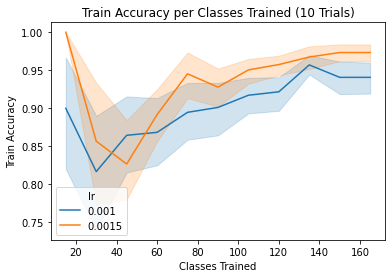

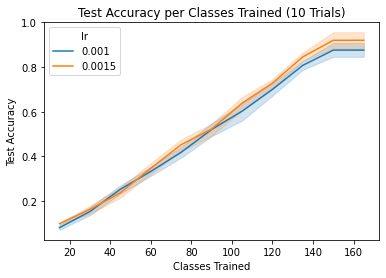

In [478]:
# For each training configuration, get a series of average performance per classes trained.
# First, we want to average over all classes to get overall performance numbers.
groupby_labels = ["model", "dataset", "num_train_examples", "num_test_examples", "lr", "classes_trained", "trial"]
per_trial_trajs = df.groupby(groupby_labels).mean()
# Now we want to aggregate these results over all trials.
group_over_trials = per_trial_trajs.groupby(groupby_labels[:-1])
# And finally we want to plot the result for each learning rate.
# perf_curve_per_lr = group_over_trials.agg([np.mean, np.std]).groupby("lr")
# for name, curve in perf_curve_per_lr:
#     x = curve.index.get_level_values("classes_trained")
#     y = curve.loc[:, ("test_acc", "mean")]
#     plt.plot(x, y, label=f"LR = {name}")
# plt.legend()
# plt.xlabel("Classes Trained")
# plt.ylabel("Accuracy")
# ntrials = df.index.get_level_values("trial").nunique()
# plt.title(f"Test Accuracy per Classes Trained ({ntrials} Trials)")
def plot_traj_per_lr(df, metric_name, colname):
    ax = sns.lineplot(data=df, x="classes_trained", y=colname, hue="lr", palette="tab10")
    ntrials = df.index.get_level_values("trial").nunique()
    ax.set_title(f"{metric_name} per Classes Trained ({ntrials} Trials)")
    ax.set_xlabel("Classes Trained")
    ax.set_ylabel(metric_name)

plt.figure()
plot_traj_per_lr(per_trial_trajs, "Train Accuracy", "train_acc")
plt.figure()
plot_traj_per_lr(per_trial_trajs, "Test Accuracy", "test_acc")

In [489]:
# Now we want to find which learning rate was the best, per data point.
group_over_trials = per_trial_trajs.groupby(groupby_labels[:-1])
# And finally we want to plot the result for each learning rate.
# perf_curve_per_lr = group_over_trials.agg([np.mean, np.std]).groupby("lr")
# for name, curve in perf_curve_per_lr:
#     x = curve.index.get_level_values("classes_trained")
#     y = curve.loc[:, ("test_acc", "mean")]
#     plt.plot(x, y, label=f"LR = {name}")

PosixPath('/')

# Slurm Job Priorities

In [192]:
import io

# TODO: Need to automatically rename PARTITION -> PARTNAME if I make this code permanent.
joblist_str = """
          JOBID PARTNAME      USER   PRIORITY       SITE        AGE      ASSOC  FAIRSHARE    JOBSIZE  PARTITION        QOS        NICE                 TRES
        8349010 dggpu     csgrasso 0.00000031          0  0.0808061  0.0000000  0.1109626  0.0026438  0.0000000  0.0000000           0          cpu=0.01,mem=0.00,gres/gpu=0.01
        8284269 dggpu     xzhang31 0.00000027          0  0.1613128  0.0000000  0.0454545  0.0028721  0.0000000  0.0000000           0          cpu=0.03,mem=0.03,gres/gpu=0.05
        8322197 dggpu     nsnichol 0.00000014          0  0.4475355  0.0000000  0.0026738  0.0024725  0.0000000  0.0000000           0          cpu=0.00,mem=0.00,gres/gpu=0.01
        8348173 dggpu       ntraft 0.00000022          0  0.0826554  0.0000000  0.0748663  0.0024725  0.0000000  0.0000000           0          cpu=0.00,mem=0.01,gres/gpu=0.01
        8348174 dggpu       ntraft 0.00000022          0  0.0826463  0.0000000  0.0748663  0.0024725  0.0000000  0.0000000           0          cpu=0.00,mem=0.01,gres/gpu=0.01
        8348104 dggpu       ntraft 0.00000022          0  0.0853985  0.0000000  0.0748663  0.0024725  0.0000000  0.0000000           0          cpu=0.00,mem=0.00,gres/gpu=0.01
        8354121 dggpu       ntraft 0.00000021          0  0.0550537  0.0000000  0.0748663  0.0024725  0.0000000  0.0000000           0          cpu=0.00,mem=0.01,gres/gpu=0.01
"""
jobs = pd.read_csv(io.StringIO(joblist_str), sep='\s+')

weights_str = """
          JOBID       SITE        AGE      ASSOC  FAIRSHARE    JOBSIZE  PARTITION        QOS                                TRES
        Weights          1       1000          0      10000       1000          0          0    CPU=1000,Mem=1000,GRES/gpu=10000
"""
weights = pd.read_csv(io.StringIO(weights_str), sep='\s+')

def tres_split(tres_str):
    vals = tres_str.split(",")
    cpu = float(vals[0].split("=")[1])
    mem = float(vals[1].split("=")[1])
    # If there is a third item present, then it is the GPU usage indicator.
    gpu = float(vals[2].split("=")[1]) if len(vals) > 2 else 0
    return [cpu, mem, gpu]

def cpu_from_tres(tres_str):
    vals = tres_str.split(",")
    return float(vals[0].split("=")[1])

def mem_from_tres(tres_str):
    vals = tres_str.split(",")
    return float(vals[1].split("=")[1])

def gpu_from_tres(tres_str):
    vals = tres_str.split(",")
    # GPU is only sometimes present; if missing, assign zero.
    return float(vals[2].split("=")[1]) if len(vals) > 2 else 0

def parse_tres(df):
    df["CPU"] = df["TRES"].apply(cpu_from_tres)
    df["MEM"] = df["TRES"].apply(mem_from_tres)
    df["GPU"] = df["TRES"].apply(gpu_from_tres)

parse_tres(jobs)
parse_tres(weights)

display(jobs)
display(weights)

def priority_components(jobs, weights):
    """
    Equation from here: https://slurm.schedmd.com/priority_multifactor.html#general
    """
    def weighted_value(jobs, weights, colname):
        if colname == "SITE":
            weight = 1.0
        elif colname == "NICE":
            weight = -1.0
        else:
            weight = weights[colname][0]
        return jobs[colname] * weight

    cols = ["SITE", "AGE", "ASSOC", "FAIRSHARE", "JOBSIZE", "PARTITION", "QOS", "CPU", "MEM", "GPU", "NICE"]
    return [weighted_value(jobs, weights, col) for col in cols]

def priority(jobs, weights):
    """
    Equation from here: https://slurm.schedmd.com/priority_multifactor.html#general
    """
    return sum(priority_components(jobs, weights))


prio = pd.concat(priority_components(jobs, weights), axis=1)
prio["PRIORITY"] = priority(jobs, weights)
prio


,JOBID,PARTNAME,USER,PRIORITY,SITE,AGE,ASSOC,FAIRSHARE,JOBSIZE,PARTITION,QOS,NICE,TRES,CPU,MEM,GPU
0,8349010,dggpu,csgrasso,3.100000e-07,0,0.080806,0.0,0.110963,0.002644,0.0,0.0,0,"cpu=0.01,mem=0.00,gres/gpu=0.01",0.01,0.00,0.01
1,8284269,dggpu,xzhang31,2.700000e-07,0,0.161313,0.0,0.045455,0.002872,0.0,0.0,0,"cpu=0.03,mem=0.03,gres/gpu=0.05",0.03,0.03,0.05
2,8322197,dggpu,nsnichol,1.400000e-07,0,0.447535,0.0,0.002674,0.002472,0.0,0.0,0,"cpu=0.00,mem=0.00,gres/gpu=0.01",0.00,0.00,0.01
3,8348173,dggpu,ntraft,2.200000e-07,0,0.082655,0.0,0.074866,0.002472,0.0,0.0,0,"cpu=0.00,mem=0.01,gres/gpu=0.01",0.00,0.01,0.01
4,8348174,dggpu,ntraft,2.200000e-07,0,0.082646,0.0,0.074866,0.002472,0.0,0.0,0,"cpu=0.00,mem=0.01,gres/gpu=0.01",0.00,0.01,0.01
5,8348104,dggpu,ntraft,2.200000e-07,0,0.085399,0.0,0.074866,0.002472,0.0,0.0,0,"cpu=0.00,mem=0.00,gres/gpu=0.01",0.00,0.00,0.01
6,8354121,dggpu,ntraft,2.100000e-07,0,0.055054,0.0,0.074866,0.002472,0.0,0.0,0,"cpu=0.00,mem=0.01,gres/gpu=0.01",0.00,0.01,0.01


,JOBID,SITE,AGE,ASSOC,FAIRSHARE,JOBSIZE,PARTITION,QOS,TRES,CPU,MEM,GPU
0,Weights,1,1000,0,10000,1000,0,0,"CPU=1000,Mem=1000,GRES/gpu=10000",1000.0,1000.0,10000.0


,SITE,AGE,ASSOC,FAIRSHARE,JOBSIZE,PARTITION,QOS,CPU,MEM,GPU,NICE,PRIORITY
0,0.0,80.8061,0.0,1109.626,2.6438,0.0,0.0,10.0,0.0,100.0,-0.0,1303.0759
1,0.0,161.3128,0.0,454.545,2.8721,0.0,0.0,30.0,30.0,500.0,-0.0,1178.7299
2,0.0,447.5355,0.0,26.738,2.4725,0.0,0.0,0.0,0.0,100.0,-0.0,576.7460
3,0.0,82.6554,0.0,748.663,2.4725,0.0,0.0,0.0,10.0,100.0,-0.0,943.7909
4,0.0,82.6463,0.0,748.663,2.4725,0.0,0.0,0.0,10.0,100.0,-0.0,943.7818
5,0.0,85.3985,0.0,748.663,2.4725,0.0,0.0,0.0,0.0,100.0,-0.0,936.5340
6,0.0,55.0537,0.0,748.663,2.4725,0.0,0.0,0.0,10.0,100.0,-0.0,916.1892


# Torch Sandbox

In [21]:
import models
from utils import calculate_output_shape

def print_modules(model):
    for k, m in model.named_modules():
        print(k, m)

def print_params(model):
    for k, p in model.named_parameters():
        print(k, p.shape)

# input_shape = [1, 28, 28]
input_shape = [3, 84, 84]
# anml, _ = models.make("anml", input_shape=input_shape, rln_chs=256, nm_chs=112, num_conv_blocks=3)
# oml, _ = models.make("oml", input_shape=input_shape)
conv4, _ = models.make("convnet4")
# resnet12, _ = models.make("resnet12")
# resnet50, _ = models.make("resnet50")
# classifier_like_anml, _ = models.make("classifier", input_shape,
#                                       encoder="convnet4",
#                                       encoder_args={"hid_dims": 256, "z_dim": 256, "padding": 0},
#                                       classifier="mlp-classifier",
#                                       classifier_args={"num_classes": 1000})
# classifier_like_oml, _ = models.make("classifier", input_shape,
#                                       encoder="convnet4",
#                                       encoder_args={"hid_dims": 64, "z_dim": 64, "num_blocks": 4, "padding": 1},
#                                       classifier="mlp-classifier",
#                                       classifier_args={"num_classes": 1000, "hidden_layers": 1024})

# print("ANML RLN out:", calculate_output_shape(anml.rln, input_shape))
# print("ANML NM out:", calculate_output_shape(anml.nm.forward_conv, input_shape))
print("Conv4 out:", calculate_output_shape(conv4.encoder, input_shape))
# print("OML RLN out:", calculate_output_shape(oml.rln, input_shape))
# print("ResNet12 out:", calculate_output_shape(resnet12, input_shape))
# print(anml)
# print(oml)
print(conv4)
# print(resnet12)

Conv4 out: torch.Size([64, 5, 5])
ConvNet(
  (encoder): Sequential(
    (0): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [9]:
def print_feature_shapes(op_sequence, input_shape):
    """
    A function to take a list or nn.Sequential and an input shape, and print the shapes of the resulting outputs.
    """
    bsize = 3
    batch_shape = (bsize,) + tuple(input_shape)
    x = torch.zeros(batch_shape)
    print(x.shape)
    for op in op_sequence:
        x = op(x)
        print(x.shape)

In [4]:
from models.oml import _conv_block

input_shape = [3, 84, 84]
planes = 64
norm_type = None
blocks = nn.Sequential(
    _conv_block(input_shape[0], planes, stride=(2, 2), norm_type=norm_type),
    _conv_block(planes, planes, stride=(1, 1), norm_type=norm_type, padding=1),
    _conv_block(planes, planes, stride=(2, 2), norm_type=norm_type),
    _conv_block(planes, planes, stride=(1, 1), norm_type=norm_type, padding=1, pool_size=2),
    _conv_block(planes, planes, stride=(2, 2), norm_type=norm_type, padding=1),
    _conv_block(planes, planes, stride=(2, 2), norm_type=norm_type),
    nn.Flatten(),
)
print_feature_shapes(blocks, input_shape)

torch.Size([3, 64, 41, 41])
torch.Size([3, 64, 41, 41])
torch.Size([3, 64, 20, 20])
torch.Size([3, 64, 10, 10])
torch.Size([3, 64, 5, 5])
torch.Size([3, 64, 2, 2])
torch.Size([3, 256])


In [18]:
import yaml
import models

cfg_str = """
model: classifier
model_args:
  encoder: convnet
  encoder_args:
    num_blocks: 3
    num_filters: 256
    padding: 0
    pool_size: [2, 2, 0]
  classifier: linear-classifier
  classifier_args: {num_classes: 1000}
"""
config = yaml.load(cfg_str, Loader=yaml.FullLoader)

input_shape = [1, 28, 28]
# input_shape = [3, 84, 84]
model, _ = models.make_from_config(config, input_shape)
seq = list(model.encoder.encoder) + [nn.Flatten(), model.classifier.linear]
print("ConvNet shapes:")
print(f"List of {len(seq)} ops.")
print_feature_shapes(seq, input_shape)

sanml, _ = models.make("sanml", input_shape=input_shape, rln_chs=256, num_conv_blocks=3)
seq = list(sanml.rln.encoder) + [nn.Flatten(), sanml.fc]
print("\nSANML shapes:")
print_feature_shapes(seq, input_shape)

print("\n")
print(model)
print("\n")
print(sanml)

ConvNet shapes:
List of 5 ops.
torch.Size([3, 1, 28, 28])
torch.Size([3, 256, 13, 13])
torch.Size([3, 256, 5, 5])
torch.Size([3, 256, 3, 3])
torch.Size([3, 2304])
torch.Size([3, 1000])

SANML shapes:
torch.Size([3, 1, 28, 28])
torch.Size([3, 256, 13, 13])
torch.Size([3, 256, 5, 5])
torch.Size([3, 256, 3, 3])
torch.Size([3, 2304])
torch.Size([3, 1000])


Classifier(
  (encoder): ConvNet(
    (encoder): Sequential(
      (0): Sequential(
        (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
        (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (relu): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (relu): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, paddi

In [17]:
import yaml
import models

cfg_str = """
model: classifier
model_args:
  encoder: convnet
  encoder_args:
    num_blocks: 6
    num_filters: 256
    stride: [2, 1, 2, 1, 2, 2]
    padding: 0
    norm_type: null
    pool_size: null
  classifier: mlp-classifier
  classifier_args: {num_classes: 1000, hidden_layers: 1024}
"""
config = yaml.load(cfg_str, Loader=yaml.FullLoader)

# input_shape = [1, 28, 28]
input_shape = [3, 84, 84]
model, _ = models.make_from_config(config, input_shape)
seq = list(model.encoder.encoder) + [nn.Flatten()] + list(model.classifier.mlp)
print("ConvNet shapes:")
print(f"List of {len(seq)} ops.")
print_feature_shapes(seq, input_shape)

oml, _ = models.make("oml", input_shape=input_shape)
seq = list(oml.rln.blocks) + list(oml.pn)
print("\nOML shapes:")
print_feature_shapes(seq, input_shape)

print("\n")
print(model)
print("\n")
print(oml)

ConvNet shapes:
List of 10 ops.
torch.Size([3, 3, 84, 84])
torch.Size([3, 256, 41, 41])
torch.Size([3, 256, 39, 39])
torch.Size([3, 256, 19, 19])
torch.Size([3, 256, 17, 17])
torch.Size([3, 256, 8, 8])
torch.Size([3, 256, 3, 3])
torch.Size([3, 2304])
torch.Size([3, 1024])
torch.Size([3, 1024])
torch.Size([3, 1000])

OML shapes:
torch.Size([3, 3, 84, 84])
torch.Size([3, 256, 41, 41])
torch.Size([3, 256, 39, 39])
torch.Size([3, 256, 19, 19])
torch.Size([3, 256, 17, 17])
torch.Size([3, 256, 8, 8])
torch.Size([3, 256, 3, 3])
torch.Size([3, 2304])
torch.Size([3, 1024])
torch.Size([3, 1024])
torch.Size([3, 1000])


Classifier(
  (encoder): ConvNet(
    (encoder): Sequential(
      (0): Sequential(
        (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2))
        (relu): ReLU()
      )
      (1): Sequential(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
      )
      (2): Sequential(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stri

# Python Sandbox

In [162]:
df = pd.DataFrame({
    'key1' : ['a','a','a','b','a','b'],
    'key2' : ['x','y','x','y','a','a'],
    'data1' : [1, 2, 2, 3, np.nan, 4],
    'data2' : list('abcdef')
})
df.set_index(['key1', 'key2'], inplace=True)
display(df)

# def mapper(dexval):
#     return 'c' if dexval == 'a' else dexval
# 
# df.rename(index=mapper)#, level='key2')

newdex = df.index.to_frame(index=False)
newdex['key1'] = ['c'] * len(newdex['key1'])
newdex = pd.MultiIndex.from_frame(newdex, names=df.index.names)
df.set_index(newdex)

data1 data2
key1 key2             
a    x       1.0     a
     y       2.0     b
     x       2.0     c
b    y       3.0     d
a    a       NaN     e
b    a       4.0     f

data1 data2
key1 key2             
c    x       1.0     a
     y       2.0     b
     x       2.0     c
     y       3.0     d
     a       NaN     e
     a       4.0     f

In [45]:
from utils import load_yaml_from_string

cfg_str = """
model: classifier
model_args:
  encoder: convnet
  encoder_args:
    num_blocks: 6
    num_filters: 256
    stride: [2, 1, 2, 1, 2, 2]
    padding: 0
    norm_type: null
    pool_size: null
  classifier: mlp-classifier
  classifier_args: {num_classes: 1000, hidden_layers: 1024}

eval: !include eval-sweep-omni-oml.yml
"""
load_yaml_from_string(cfg_str, base_dir=Path("../configs"))

{'model': 'classifier',
 'model_args': {'encoder': 'convnet',
  'encoder_args': {'num_blocks': 6,
   'num_filters': 256,
   'stride': [2, 1, 2, 1, 2, 2],
   'padding': 0,
   'norm_type': None,
   'pool_size': None},
  'classifier': 'mlp-classifier',
  'classifier_args': {'num_classes': 1000, 'hidden_layers': 1024}},
 'eval': {'dataset': 'omni',
  'train_examples': 15,
  'test_examples': 5,
  'reinit_params': 'pn.2',
  'opt_params': 'pn',
  'classes': 600,
  'lr': [0.1,
   0.05,
   0.01,
   0.005,
   0.001,
   0.0009,
   0.0008,
   0.0007,
   0.0006,
   0.0005,
   0.0004,
   0.0003,
   0.0002,
   0.0001,
   5e-05,
   1e-05]}}